# 1) Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2) Load the dataset

Display the first few rows of the dataset

In [3]:
DATASET_PATH = r"../data/dataset_small.csv"
df = pd.read_csv(DATASET_PATH)

df.head()

C:\Users\fedor\AppData\Local\Temp\ipykernel_1960\240890764.py:2: DtypeWarning: Columns (1672) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATASET_PATH)


,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_1664,pixel_1665,pixel_1666,pixel_1667,pixel_1668,pixel_1669,pixel_1670,pixel_1671,pixel_1672,label
0,-5.254530,-0.569596,6.344805,-3.380917,3.203426,-1.143426,-7.891048,-2.610459,-0.963249,-0.505788,...,-0.101692,-0.077913,-0.852660,0.530346,0.039475,-1.053974,-0.146754,0.228751,-0.631907,0
1,-9.995496,-4.633731,6.613166,0.829315,9.566810,-2.032633,-4.936915,-3.793391,-3.447060,-0.398183,...,-0.141613,-1.646326,-0.642386,1.383142,-0.242347,-1.253635,-0.741404,0.121868,-0.240069,0
2,-4.009331,-7.283738,-2.343139,3.853363,-5.308279,-5.684689,-3.064548,4.745645,1.028596,1.361845,...,-0.698284,0.667050,0.482680,0.212994,0.169312,-0.179353,-0.886870,0.637208,0.657808,0
3,-2.030828,-5.593181,-11.259305,-0.493159,6.978751,5.678419,-0.813766,4.897509,-2.776486,-0.613106,...,0.416916,-0.374833,0.149815,0.574161,-0.220023,0.698690,-1.338986,0.280161,-0.842836,0
4,-8.424750,-9.250905,4.228565,4.875258,3.498729,-10.048499,-4.697092,-0.551032,-3.204560,-0.759171,...,0.592175,-0.385816,0.455523,-0.036047,-0.267697,-0.779007,-0.149019,1.006753,-1.003270,0


In [13]:
X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy().astype(str)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

In [8]:
os.environ['HTTP_PROXY'] = os.getenv('HTTP_PROXY')

In [14]:
torch.cuda.empty_cache()

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [10]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        inputs = {key: value.squeeze(0) for key, value in inputs.items()}
        label = self.labels[idx] if self.labels is not None else None
        return inputs, label

In [11]:
def get_bert_embeddings(dataloader, model):
    """Generate embeddings for all texts in the dataloader using BERT."""
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {key: value.to(device) for key, value in batch[0].items()}
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.extend(embeddings)
    return np.array(all_embeddings)

In [16]:
# Convert data to PyTorch Datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Use DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# %%
# Generate BERT embeddings
X_train_bert = get_bert_embeddings(train_loader, model)
X_test_bert = get_bert_embeddings(test_loader, model)

100%|██████████| 1243/1243 [06:24<00:00,  3.23it/s]


In [17]:
clf = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42, n_jobs=-1, verbose=1)
clf.fit(X_train_bert, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 14.97, NNZs: 768, Bias: -6.612467, T: 159096, Avg. loss: 0.330396
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 16.88, NNZs: 768, Bias: -3.422004, T: 159096, Avg. loss: 1.268266
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 12.33, NNZs: 768, Bias: -6.794570, T: 159096, Avg. loss: 0.494205
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 13.76, NNZs: 768, Bias: -6.734806, T: 159096, Avg. loss: 1.304415
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 12.76, NNZs: 768, Bias: -8.359263, T: 159096, Avg. loss: 0.851427
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 19.51, NNZs: 768, Bias: -8.123644, T: 159096, Avg. loss: 1.214358
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 18.22, NNZs: 768, Bias: -7.878904, T: 159096, Avg. loss: 1.233966
Total training time: 0.45 seconds.
-- Epoch 

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.8s


Norm: 7.37, NNZs: 768, Bias: -4.928643, T: 1431864, Avg. loss: 0.048954
Total training time: 4.53 seconds.
-- Epoch 10
Norm: 7.60, NNZs: 768, Bias: -6.974313, T: 636384, Avg. loss: 0.122802
Total training time: 1.85 seconds.
-- Epoch 5
Norm: 6.86, NNZs: 768, Bias: -4.191208, T: 1590960, Avg. loss: 0.098599
Total training time: 4.59 seconds.
-- Epoch 11
Norm: 5.45, NNZs: 768, Bias: -5.274557, T: 1590960, Avg. loss: 0.068151
Total training time: 4.53 seconds.
-- Epoch 11
Norm: 4.19, NNZs: 768, Bias: -5.616622, T: 1590960, Avg. loss: 0.039687
Total training time: 4.55 seconds.
Convergence after 10 epochs took 4.55 seconds
Norm: 5.01, NNZs: 768, Bias: -7.185661, T: 1431864, Avg. loss: 0.080785
Total training time: 4.43 seconds.
-- Epoch 10
-- Epoch 1
Norm: 5.51, NNZs: 768, Bias: -5.579944, T: 1431864, Avg. loss: 0.020394
Total training time: 4.23 seconds.
Convergence after 9 epochs took 4.23 seconds
-- Epoch 1
Norm: 5.29, NNZs: 768, Bias: -6.621217, T: 1431864, Avg. loss: 0.020529
Total tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   27.8s finished


SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42, verbose=1)

In [18]:
# Make predictions on the test set
y_pred = clf.predict(X_test_bert)

In [19]:
# Evaluate the model
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.2358
Recall: 0.1739
F1 Score: 0.1338


c:\Users\fedor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


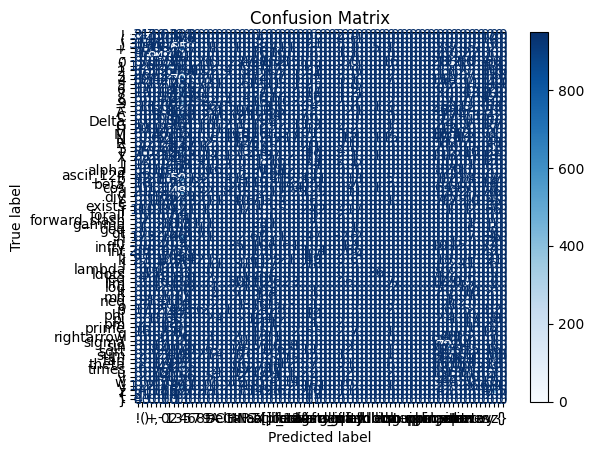

In [20]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()